# Data Wrangling - Spotify Top 200

### Introduction
In this project we will look at multiple questions regarding the Top 200 Spotify songs. For this we will look at the sentiment of the lyrics and combine this data with other datasets to hopefully derive some interesting conclusions. Every section in this notebok represents a research question regarding this topic.

Group members of this project:
<ul>
    <li>Luuk Kaandorp (2623537)</li>
    <li>Lucas de Geus</li>
    <li>Ward Pennink</li>
    <li>Matthijs Blaauw</li>
</ul>

### Import
This section imports every function and package used in the following sections, please run this before running all others.

In [1]:
# read neccessary libraries for pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
np.set_printoptions(precision = 4, suppress = True)

# read neccessary libraries for getting the lyrics
import requests
from bs4 import BeautifulSoup

# read neccessary libraries for sentiment analysis (see cell below for acknowledgement)
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# read neccessary libraries for text pre-processing
import string

# read neccessary libraries for language detection
from langdetect import detect

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Acknowledgement
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

### Q1: Proportion of songs with positive sentiment compared to songs with negative sentiment in the Top 200

This question tries to answer whether there are more songs with a positive sentiment in the Top 200 than songs with a negative sentiment. In the code field below we start by getting the weekly Top 200 from the US on Spotify in the week of 09-01-2020 to 16-01-2020.

In [2]:
# this reads in the Spotify Top 200 of the US of this week
this_weeks_top200_file = "regional-us-weekly-latest.csv"
this_weeks_top200 = pd.read_csv(this_weeks_top200_file, header=1)
this_weeks_top200 = pd.DataFrame(this_weeks_top200.head(50))
this_weeks_top200

,Position,Track Name,Artist,Streams,URL
0,1,The Box,Roddy Ricch,18952305,https://open.spotify.com/track/0nbXyq5TXYPCO7p...
1,2,ROXANNE,Arizona Zervas,9671478,https://open.spotify.com/track/696DnlkuDOXcMAn...
2,3,Yummy,Justin Bieber,9648561,https://open.spotify.com/track/41L3O37CECZt3N7...
3,4,Circles,Post Malone,8244725,https://open.spotify.com/track/21jGcNKet2qwijl...
4,5,BOP,DaBaby,7985170,https://open.spotify.com/track/6Ozh9Ok6h4Oi1wU...
...,...,...,...,...,...
45,46,Señorita,Shawn Mendes,3289924,https://open.spotify.com/track/6v3KW9xbzN5yKLt...
46,47,Goodbyes (Feat. Young Thug),Post Malone,3266958,https://open.spotify.com/track/6vBdBCoOhKHiYDD...
47,48,No Guidance (feat. Drake),Chris Brown,3216358,https://open.spotify.com/track/6XHVuErjQ4XNm6n...
48,49,Death,Trippie Redd,3176458,https://open.spotify.com/track/3Kd6Wp3lG5HXMB2...


Now we got the songs we need, we need to establish a function which gets the lyrics for the given song. We use the Genius API to get the lyrics. We also need a function which processes the result. The last function we need is the one that scrapes the lyrics from the html page we get from the request. The below code section contains these functions.

In [3]:
# this function requests the song info based on the artist and song title
def request_song_info(song_title, artist_name):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + '2wN0egWOzQ-_KQDN4XkblxZoUjG2H_Zl-xq3uXNJhVFNaIkaM0QfvSWM4pm3fWhw'}
    search_url = base_url + '/search'
    data = {'q': song_title + ' ' + artist_name}
    response = requests.get(search_url, data=data, headers=headers)

    return response

# this function processes the result of the info request
def process_request(response, artist_name):
    json = response.json()
    remote_song_info = None

    for hit in json['response']['hits']:
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
            remote_song_info = hit
            break
            
    if remote_song_info:
        return remote_song_info['result']['url']
    else :
        return ""
    
# this function scraps the lyrics from the html page
def scrap_lyrics(url):
    if url != "":
        page = requests.get(url)
        html = BeautifulSoup(page.text, 'html.parser')
        lyrics = html.find('div', class_='lyrics').get_text()
        # we detect the language of the lyrics, since the function that comes later in this document can only
        # calculate the sentiment of english lyrics we won't process lyrics that are not english
        if detect(lyrics) == "en":
            return process_lyrics(lyrics)
    return ""
# this function pre-processes the lyrics
def process_lyrics(lyrics):
    # replace enter (\n) with space
    enter_removed = lyrics.replace('\u2005', ' ').replace('\n', ' ')
    
    # remove punctuatin
    punctuation_removed = enter_removed.translate(str.maketrans("","", string.punctuation)) 
    
    return punctuation_removed
            
# TEST
test_lyrics = scrap_lyrics(process_request(request_song_info('The Box', 'Roddy Ricch'), 'Roddy Ricch'))
test_lyrics

'  Chorus Pullin out the coupe at the lot Told em fuck 12 fuck SWAT Bustin all the bales out the box I just hit a lick with the box Had to put the stick in a box mmh Pour up the whole damn seal Ima get lazy I got the mojo deals we been trappin like the 80s She sucked a nigga soul got the Cash App Told em wipe a nigga nose say slatt slatt I wont never sell my soul and I can back that And I really wanna know where you at at  Verse 1 I was out back where the stash at Cruise the city in a bulletproof Cadillac Skrrt Cause I know these niggas after where the bag at Yeah Gotta move smarter gotta move harder Nigga try to get me for my water Ill lay his ass down on my son on my daughter I had the Draco with me Dwayne Carter Lotta niggas out here playin aint ballin I done put my whole arm in the rim Vince Carter Yeah And I know probably get a key for the quarter Shawty barely seen in double Cs I bought em Got a bitch thats looking like Aaliyah she a model I got the pink slip all my whips is keyl

Now that we have the correct functions, we can get the lyrics for all the songs in the Top200. All we need now is a function which determines the sentiment of the lyrics. 

In [4]:
# this function calculates the sentiment of the lyrics
def sentiment_of_lyrics(lyrics):
    if lyrics != "":
        sid = SentimentIntensityAnalyzer()
        return sid.polarity_scores(lyrics)
    else:
        return False

# TEST
sentiment_of_lyrics(test_lyrics)

{'neg': 0.133, 'neu': 0.79, 'pos': 0.077, 'compound': -0.9896}

We now have everything we need: the songs, the lyrics and the sentiment processor. In the following section we create the final table containing the songs and their sentiment. Note that creating this table can take up to 10 minutes!

In [6]:
# calculate sentiment for all songs in a Top200
def sentiment_for_top200(top200):
    for index, row in top200.iterrows():
        sentiment = sentiment_of_lyrics(scrap_lyrics(process_request(request_song_info(row['Track Name'], row['Artist']), row['Artist'])))
        if (sentiment != False):
            top200.loc[index,'neg_sentiment'] = sentiment.get('neg')
            top200.loc[index,'neu_sentiment'] = sentiment.get('neu')
            top200.loc[index,'pos_sentiment'] = sentiment.get('pos')
            top200.loc[index,'compound_sentiment'] = sentiment.get('compound')
        else:
            top200.loc[index,'neg_sentiment'] = 0
            top200.loc[index,'neu_sentiment'] = 0
            top200.loc[index,'pos_sentiment'] = 0
            top200.loc[index,'compound_sentiment'] = 0
    return top200

processed_this_weeks_top200 = sentiment_for_top200(this_weeks_top200)
processed_this_weeks_top200

KeyboardInterrupt: 

We now have the table containing the top 200 songs on Spotify with their corresponding sentiment based on their lyrics. We will also use this table in further sections. We will now look at the proportion of negative and positive lyrics based on their compound sentiment to answer our question.

In [7]:
# the number of positive sentiment lyrics
this_weeks_compound_sentiment = processed_this_weeks_top200['compound_sentiment']
this_weeks_num_positive = this_weeks_compound_sentiment[this_weeks_compound_sentiment > 0.5 ].count()

# the number of negative sentiment lyrics
this_weeks_num_negative = this_weeks_compound_sentiment[this_weeks_compound_sentiment < 0.5 ].count()

print("Songs with positive sentiment: " + str(this_weeks_num_positive))
print("Songs with negative sentiment: " + str(this_weeks_num_negative))

NameError: name 'processed_this_weeks_top200' is not defined

In order to not have to repeat the code above every time we want to compute the compound sentiment for a week, we wrap the above code in a function, called compound_sentiment. This function takes the file for which the compound sentiment needs to be calculated as parameter, and returns a tuple containing the number of songs with a positive sentiment and the number of songs with a negative sentiment. 

In [8]:
def compound_sentiment_function(file):    
    top50 = pd.DataFrame(pd.read_csv(file, header=1).head(50))

    # creates augmented top50 table with sentiment
    processed_top50 = sentiment_for_top200(top50)
    top50_compound_sentiment = processed_top50['compound_sentiment']
    
    # the number of positive sentiment lyrics    
    top50_num_positive = top50_compound_sentiment[top50_compound_sentiment > 0.5 ].count()

    # the number of negative sentiment lyrics
    top50_num_negative = top50_compound_sentiment[top50_compound_sentiment < 0.5 ].count()
    
    return (top50_num_positive, top50_num_negative)

As you can see from the result, there is only a small difference between the positive and negative sentiment. We consider this difference to be negligable. Therefore we decided to also look at the 2 weeks before this week to see if this holds for multiple weeks or was just coincidence. In the below code field we look at the week before (02-01-2020 to 09-01-2020). Note that creating this table can also take up to 10 minutes!

In [9]:
# this reads in the Spotify Top 200 of the US of the week before and calculates the sentiment
compound_sentiment_week_before = compound_sentiment_function("regional-us-weekly-2019-12-27--2020-01-03.csv")

print("Songs with positive sentiment: " + str(compound_sentiment_week_before[0]))
print("Songs with negative sentiment: " + str(compound_sentiment_week_before[1]))

KeyboardInterrupt: 

In the following code field we look at the week 2 weeks before this week (26-12-2019 to 02-01-2020). Note that creating this table can also take up to 10 minutes!

In [ ]:
# this reads in the Spotify Top 200 of the US of 2 weeks before
compound_sentiment_2weeks = compound_sentiment_function("regional-us-weekly-2019-12-20--2019-12-27.csv")

print("Songs with positive sentiment: " + str(compound_sentiment_2weeks[0]))
print("Songs with negative sentiment: " + str(compound_sentiment_2weeks[1]))

As you can see, 2 weeks before was around Christmas time and it had a lot more songs in the top 200 with a positive sentiment than songs with negative sentiment. We know from the numbers that the top 200 tends to contain more songs with positive sentiment than songs with negative sentiment. In the next code field we calculate the difference in percentage.

In [ ]:
# we calculate the total number of positive and negative songs
total_positive_all_weeks = this_weeks_num_positive + compound_sentiment_week_before[0] + compound_sentiment_2weeks[0]
total_negative_all_weeks = this_weeks_num_negative + compound_sentiment_week_before[1] + compound_sentiment_2weeks[1]

# we calculate the difference between positive and negative songs in percentage
difference = ((total_positive_all_weeks - total_negative_all_weeks) / total_negative_all_weeks) * 100
print("In the last 3 weeks, we see that there are " + str(round(difference, 2)) + "% more songs with positive sentiment in their lyrics in the Top200 than negative.")

Our conclusion is that it seems like there are not notably more songs with a positive sentiment than ones with negative sentiments in 'normal' weeks without holidays based on the last 3 weeks. We saw that the week around Christmas was an exception to this conclusion and therefore we investigate this further in the following section

### Q2: Influence of holidays on the sentiment listened to

This question tries to answer whether people tend to listen more to songs with a positive sentiment than songs with a negative sentiment during weeks around holidays. For this question we will look at the 2 weeks around the holidays Christmas, Easter and Thanksgiving. Because we have already looked at the Christmas period for 2019, this question looks at the holiday periods of 2018. 

In [ ]:
christmas2018 = compound_sentiment_function("regional-us-weekly-2018-12-21--2018-12-28.csv")

print("Songs with positive sentiment: " + str(christmas2018[0]))
print("Songs with negative sentiment: " + str(christmas2018[1]))

In [ ]:
easter2018 = compound_sentiment_function("regional-us-weekly-2018-03-30--2018-04-06.csv")

print("Songs with positive sentiment: " + str(easter2018[0]))
print("Songs with negative sentiment: " + str(easter2018[1]))

In [ ]:
thanksgiving2018 = compound_sentiment_function("regional-us-weekly-2018-11-16--2018-11-23.csv")

print("Songs with positive sentiment: " + str(thanksgiving2018[0]))
print("Songs with negative sentiment: " + str(thanksgiving2018[1]))

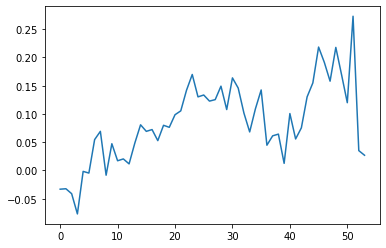

In [10]:
from os import listdir
from os.path import isfile, join
import csv

weekLists = [f for f in listdir('dataUs') if isfile(join('dataUs', f))]

import matplotlib.pyplot as plt

sentiments = []
postive_songs = []
negative_songs = []
for file in weekLists:
    avg_sentiment = float(0)
    num_records = 0
    num_postive_songs = 0
    num_negative_songs = 0
    with open('dataUs/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            # compound sentiment
            if row[7] != 'none':
                num_records += 1
                avg_sentiment += float(row[7])
            # positive sentiment
            if row[6] != 'none' and float(row[6]) > 0.3:
                num_postive_songs += 1
            if row[4] != 'none' and float(row[4]) > 0.3:
                num_negative_songs += 1
    avg_sentiment = avg_sentiment / num_records
    sentiments.append(avg_sentiment)
    postive_songs.append(num_postive_songs)
    negative_songs.append(num_negative_songs)

plt.plot(sentiments)


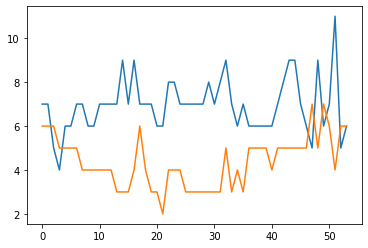

In [11]:
plt.plot(postive_songs)
plt.plot(negative_songs)

200


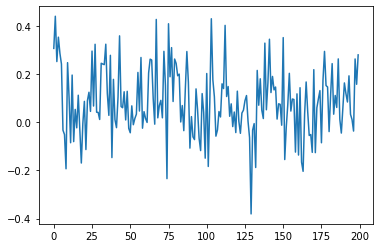

In [12]:
positions_sentiments = []

for i in range(0, 200):
    positions_sentiments.append([])

print(len(positions_sentiments))

for file in weekLists:
    avg_sentiment = float(0)
    with open('dataUs/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            # compound sentiment
            if row[7] != 'none':
                positions_sentiments[index - 1].append(float(row[7]))

position_avg_sentiments = []

for index, row in enumerate(positions_sentiments):
    position_avg_sentiments.append(sum(row) / float(len(row)))

plt.plot(position_avg_sentiments)

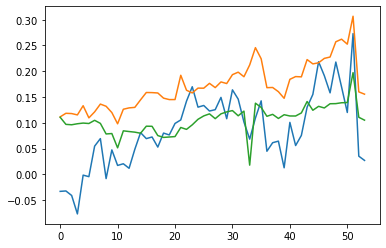

In [13]:
weekLists = [f for f in listdir('dataUs') if isfile(join('dataUs', f))]

usSentiments = []
ukSentiments = []
auSentiemnts = []
for file in weekLists:
    avg_sentiment = float(0)
    num_records = 0

    with open('dataUs/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            # compound sentiment
            if row[7] != 'none':
                num_records += 1
                avg_sentiment += float(row[7])
    avg_sentiment = avg_sentiment / num_records
    usSentiments.append(avg_sentiment)
    
    with open('dataGb/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            # compound sentiment
            if row[7] != 'none':
                num_records += 1
                avg_sentiment += float(row[7])
    avg_sentiment = avg_sentiment / num_records
    ukSentiments.append(avg_sentiment)
    
    with open('dataAu/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            # compound sentiment
            if row[7] != 'none':
                num_records += 1
                avg_sentiment += float(row[7])
    avg_sentiment = avg_sentiment / num_records
    auSentiemnts.append(avg_sentiment)

plt.plot(usSentiments)
plt.plot(ukSentiments)
plt.plot(auSentiemnts)

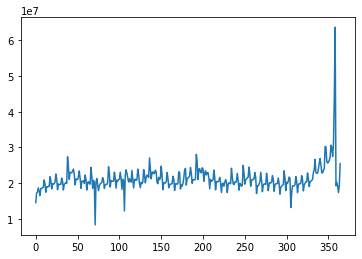

In [16]:
days = [f for f in listdir('dataGbDay') if isfile(join('dataGbDay', f))]

totalStreamsPerDay = []
totalPostiveStreamsPerDay = []
totalNegativeStreamsPerDay = []
for file in days:
    
    with open('dataGbDay/' + file, newline='', encoding="utf-8") as csvfile:
        tempStreams = 0
        tempPosStreams = 0
        tempNegStreams = 0
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            if row[6] != 'none' and float(row[6]) > 0.3:
                tempPosStreams += float(row[2])
            if row[4] != 'none' and float(row[4]) > 0.3:
                tempNegStreams += float(row[2])
            tempStreams += float(row[2])
    totalStreamsPerDay.append(tempStreams)
    totalPostiveStreamsPerDay.append(tempPosStreams)
    totalNegativeStreamsPerDay.append(tempNegStreams)

plt.plot(totalStreamsPerDay)
# plt.plot(totalPostiveStreamsPerDay)
# plt.plot(totalNegativeStreamsPerDay)

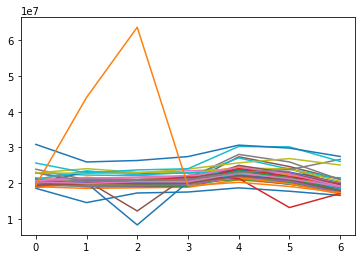

In [17]:
from datetime import datetime

days = [f for f in listdir('dataGbDay') if isfile(join('dataGbDay', f))]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

streamsPerWeekday = [0, 0, 0, 0, 0, 0, 0]
for file in days:
    with open('dataGbDay/' + file, newline='', encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        totalStreams = 0
        for index, row in enumerate(reader):
            if (index == 0):
                continue
            totalStreams += float(row[2])
        date = datetime.strptime(file.split('.')[0], '%Y-%m-%d')
        streamsPerWeekday[weekdays.index(date.strftime("%A"))] += totalStreams
        if (date.strftime("%A") == 'Monday'):
            plt.plot(streamsPerWeekday)
            streamsPerWeekday = [0, 0, 0, 0, 0, 0, 0]
        
